Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10600     
                                                                 
 self_attention_layer (Self  (None, 10, 50)            40650     
 AttentionLayer)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 25)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 10, 25)            5100      
                                                                 
 lstm_3 (LSTM)               (None, 10, 50)            1

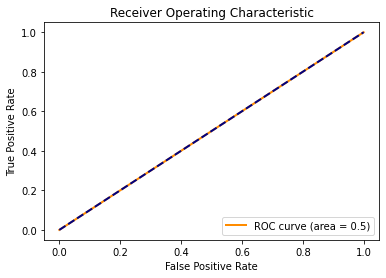

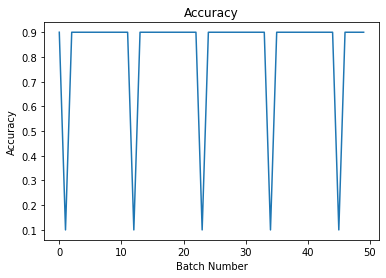

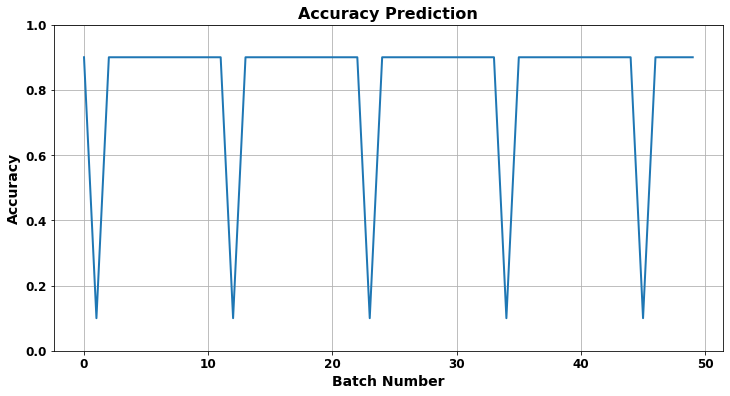

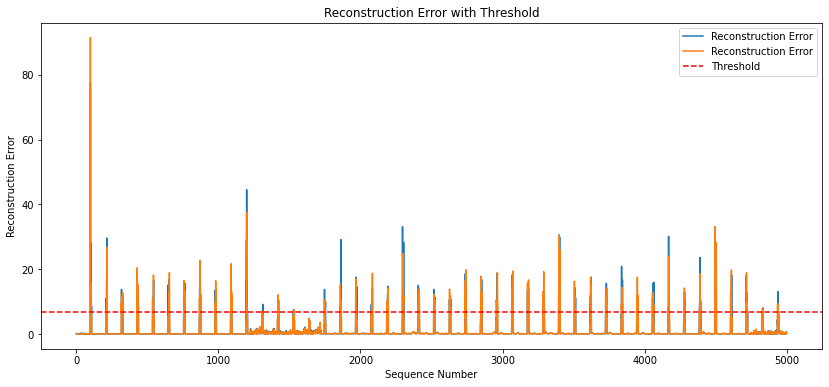

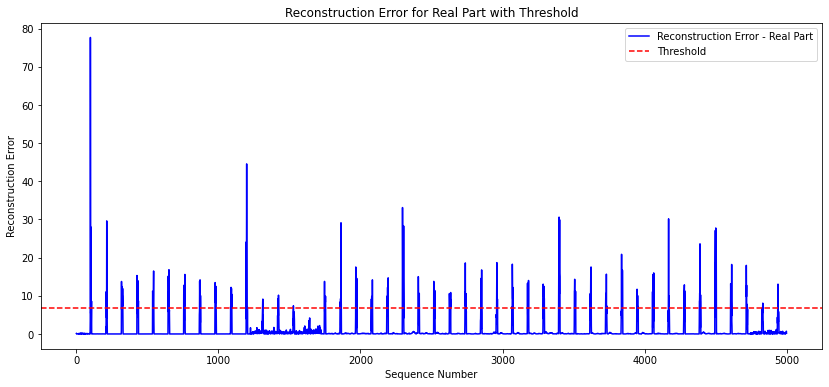

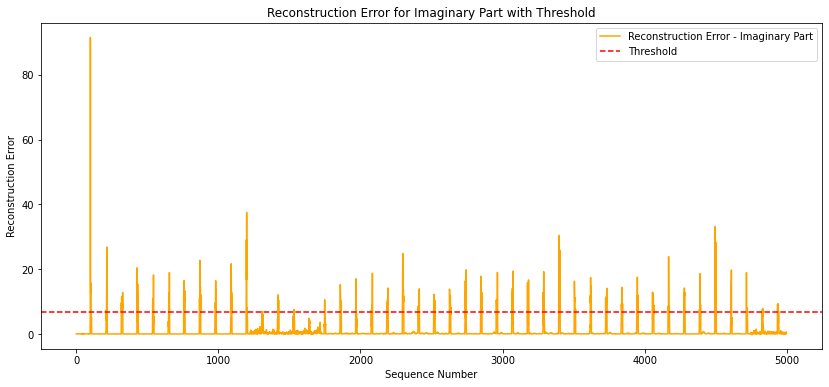

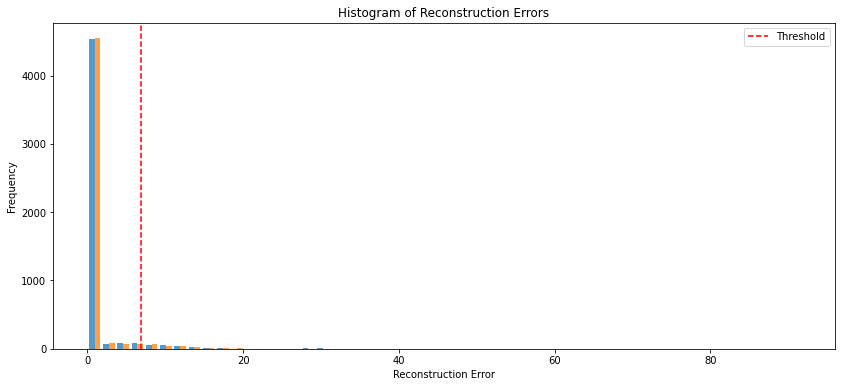

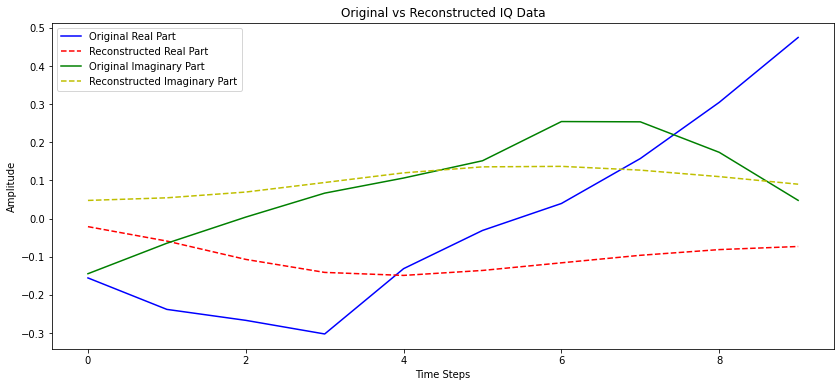

Shape of avg_real: (100,)
Shape of avg_imag: (100,)
Shape of last_errors: 100


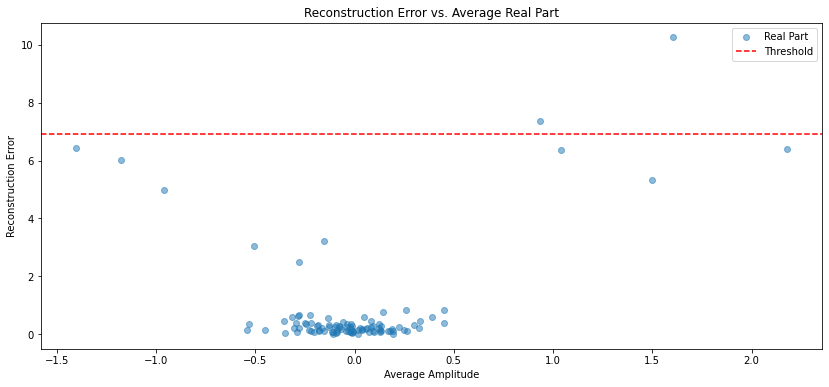

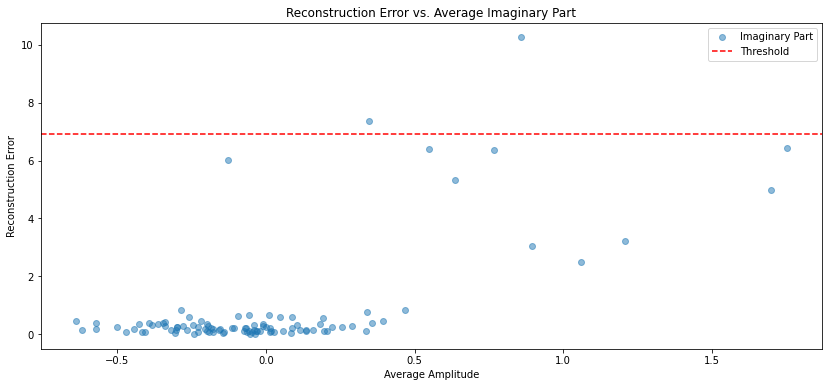

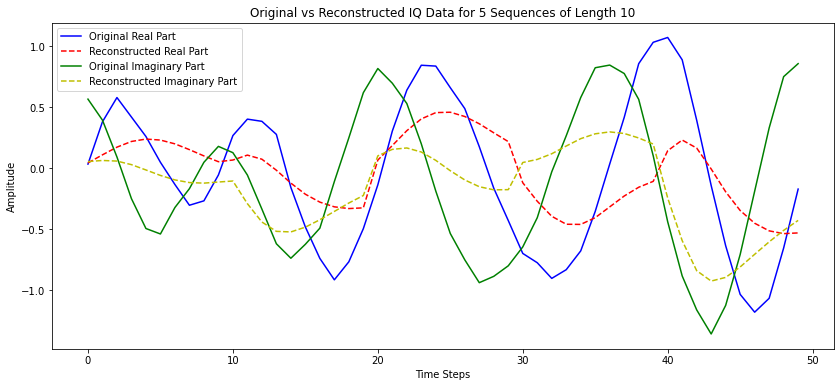

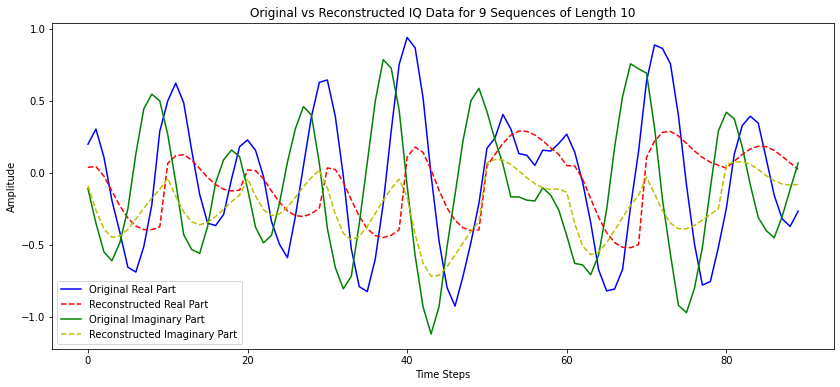

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, MultiHeadAttention, Layer
#from tensorflow_addons.layers import MultiHeadAttention
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score

def load_data(filepath):
    _, file_extension = os.path.splitext(filepath)
    
    if file_extension == '.csv':
        df = pd.read_csv(filepath)
        samples = df['your_column_name'].values
    elif file_extension == '.dat':
        #Looks like DAT is binary encoded added a b in r as rb
        with open(filepath, 'rb') as f:
            samples = f.readlines()
        samples = np.array([sample.strip() for sample in samples])
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    return samples

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)

class CSVDataGenerator:
    def __init__(self, file_pattern, batch_size, sequence_length, max_samples=None, for_training=True):     
        self.file_pattern = file_pattern
        self.file_list = sorted(glob.glob(self.file_pattern))
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.current_file_idx = 0
        self.dataframe_iterator = None
        self.labels_iterator = None
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0

    def _load_next_file(self):
        if self.current_file_idx >= len(self.file_list):
            print("No more files to process.")
            raise StopIteration

        current_file = self.file_list[self.current_file_idx]
        df = pd.read_csv(current_file)

        # Filter out rows where 'IQ Data' is '0j'
        df['IQ Data'] = df['IQ Data'].apply(lambda x: complex(x.replace('i', 'j')))
        df = df[df['IQ Data'] != 0j]

        # Check if DataFrame is empty or 'IQ Data' column is missing
        if df.empty or 'IQ Data' not in df.columns:
            raise ValueError(f"File {current_file} is empty or missing 'IQ Data' column after filtering 0j.")

        # If not for training, extract the labels
        if not self.for_training and 'label' in df.columns:
            self.labels_iterator = iter(df['label'].map(lambda x: 1 if x == 'jammer' else 0).values)
        else:
            self.labels_iterator = None

        print(f"Processing file: {current_file}")
        self.dataframe_iterator = iter(df['IQ Data'].values)
        self.current_file_idx += 1

    # Reset function to be used when switching from training to prediction
    def reset_for_prediction(self):
        self.current_file_idx = 0
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self.dataframe_iterator = None
        self._load_next_file()  # Start from the first file again

    def __iter__(self):
        self.current_file_idx = 0
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self._load_next_file()
        return self

#     def process_data(self, samples):
#         real_parts = np.real(samples)
#         imag_parts = np.imag(samples)

#         real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
#         imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

#         X = np.array(list(zip(real_parts, imag_parts))).reshape(-1, self.sequence_length, 2)
#         return X
    def process_data(self, samples):
        # Apply FFT to convert time-domain signals into frequency domain
        samples_fft = fft(samples)
        
        # Extract real and imaginary parts
        real_parts = np.real(samples_fft)
        imag_parts = np.imag(samples_fft)
        
        # Normalize the real and imaginary parts
        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)
        
        # Extract statistical features from the real and imaginary parts
        features = np.column_stack((
            np.mean(real_parts, axis=1),
            np.std(real_parts, axis=1),
            skew(real_parts, axis=1),
            kurtosis(real_parts, axis=1),
            np.mean(imag_parts, axis=1),
            np.std(imag_parts, axis=1),
            skew(imag_parts, axis=1),
            kurtosis(imag_parts, axis=1)
        ))
        
        # Reshape features to match the input shape of the model
        X = features.reshape(-1, self.sequence_length, features.shape[1])
        # Print processed data (only for the first batch or occasionally)
        if self.total_samples_processed < self.batch_size:  # Adjust the condition as needed
            print(f"Processed data (after FFT and feature extraction): {X[:5]}")
        return X
    def __next__(self):
        if self.max_samples and self.total_samples_processed >= self.max_samples:
            raise StopIteration("Reached max_samples limit.")

        while len(self.samples_buffer) < self.batch_size * self.sequence_length:
            try:
                chunk = next(self.dataframe_iterator)
                self.samples_buffer.append(chunk)
                if not self.for_training and self.labels_iterator is not None:
                    label_chunk = next(self.labels_iterator)
                    self.labels_buffer.append(label_chunk)
            except StopIteration:
                if self.current_file_idx >= len(self.file_list):
                    raise StopIteration("No more data to process.")
                self._load_next_file()

        samples = self.samples_buffer[:self.batch_size * self.sequence_length]
        self.samples_buffer = self.samples_buffer[self.batch_size * self.sequence_length:]
        
        # Print some raw samples (only for the first batch or occasionally)
        if self.total_samples_processed < self.batch_size:  # Adjust the condition
            print(f"Raw samples (before processing): {self.samples_buffer[:5]}")

        X_chunk = self.process_data(np.array(samples))

        if not self.for_training:
            labels = self.labels_buffer[:self.batch_size * self.sequence_length]
            self.labels_buffer = self.labels_buffer[self.batch_size * self.sequence_length:]
            return X_chunk, np.array(labels)
        else:
            return X_chunk, X_chunk
    def close(self):
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self.current_file_idx = 0
        self.dataframe_iterator = None
        self.labels_iterator = None   
#-----------------------------6----------------------------------------
# def plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path):
#     for idx in range(0, len(all_X_chunk_test), sequence_length):
#         sequence_idx = idx // sequence_length
#         if all_intrusion_flags[sequence_idx]:
#             plt.figure(figsize=(14, 6))
#             time_steps = np.arange(idx * sequence_length, (idx + 1) * sequence_length)

#             real_part_test = all_X_chunk_test[idx, :, 0].reshape(-1)
#             imag_part_test = all_X_chunk_test[idx, :, 1].reshape(-1)
#             real_part_pred = all_X_chunk_pred[idx, :, 0].reshape(-1)
#             imag_part_pred = all_X_chunk_pred[idx, :, 1].reshape(-1)

#             plt.plot(time_steps, real_part_test, 'b-', label='Original Real', linewidth=2)
#             plt.plot(time_steps, real_part_pred, 'r--', label='Reconstructed Real', linewidth=2)
#             plt.plot(time_steps, imag_part_test, 'g-', label='Original Imag', linewidth=2)
#             plt.plot(time_steps, imag_part_pred, 'y--', label='Reconstructed Imag', linewidth=2)
            
#             plt.fill_between(time_steps, -3, 3, where=True, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')
#             plt.legend(loc='lower right')
#             plt.title(f'8-IQ Data: Original vs Reconstructed with Intrusion Highlighted (Sequence {sequence_idx})')
#             plt.xlabel('Sample Index')
#             plt.ylabel('Normalized Value')
#             plt.tight_layout()

#             filename = os.path.join(save_path, f'intrusion_sequence_{sequence_idx}.png')
#             plt.savefig(filename)
#             plt.close()


def plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path):
    for idx in range(0, len(all_X_chunk_test), sequence_length):
        sequence_idx = idx // sequence_length
        if all_intrusion_flags[sequence_idx]:
            plt.figure(figsize=(14, 6))
            time_steps = np.arange(idx * sequence_length, (idx + 1) * sequence_length)

            real_part_test = all_X_chunk_test[idx, :, 0].reshape(-1)
            imag_part_test = all_X_chunk_test[idx, :, 1].reshape(-1)
            real_part_pred = all_X_chunk_pred[idx, :, 0].reshape(-1)
            imag_part_pred = all_X_chunk_pred[idx, :, 1].reshape(-1)

            plt.plot(time_steps, real_part_test, 'b-', label='Original Real', linewidth=2)
            plt.plot(time_steps, real_part_pred, 'r--', label='Reconstructed Real', linewidth=2)
            plt.plot(time_steps, imag_part_test, 'g-', label='Original Imag', linewidth=2)
            plt.plot(time_steps, imag_part_pred, 'y--', label='Reconstructed Imag', linewidth=2)
            
            # Define where the fill should be applied (assuming the entire range for this example)
            where_fill = np.full_like(time_steps, True, dtype=bool)  # Fill the entire range
            plt.fill_between(time_steps, -3, 3, where=where_fill, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')

            #plt.fill_between(time_steps, -3, 3, where=True, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')
            
            # Enhancing font size and making bold
            plt.title(f'Original vs Reconstructed with Intrusion (Sequence {sequence_idx})', fontsize=18, fontweight='bold')
            plt.xlabel('Sample Index', fontsize=16, fontweight='bold')
            plt.ylabel('IQ Sample', fontsize=16, fontweight='bold')
            plt.legend(loc='lower right', fontsize=15)

            # Enhancing xtick and ytick labels
            for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
                label.set_fontsize(13)
                label.set_fontweight('bold')

            plt.tight_layout()

            filename = os.path.join(save_path, f'intrusion_sequence_{sequence_idx}.png')
            plt.savefig(filename)
            plt.close()

sequence_length = 10
#-------------------------------SelfAttention-RNN---------------------------------------
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)

model = Sequential()
# Input LSTM layer
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 8), return_sequences=True))  # Adjusted input_shape
# Self-attention layer
model.add(SelfAttentionLayer(num_heads=4, key_dim=50))
# Rest of the model remains the same
model.add(LSTM(25, activation='relu', return_sequences=False))
model.add(RepeatVector(sequence_length))
model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(8)))  # Adjusted units in Dense layer

model.summary()
model.compile(optimizer='adam', loss='mse')
batch_size = 20

max_train_samples = 200000  # I limit the train or can put None for whole data
train_steps = (max_train_samples) // (batch_size * sequence_length)
max_samples = 200000  # Maximum samples to read (or None to read all)
max_test_samples = 1000000

# Example file patterns
pure_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\pure_data\\pure_iq_samples_*.csv'
mixed_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\mixed_data\\mixed_iq_samples_*.csv'

num_epochs = 5  # You can adjust the number of epochs as needed
steps_per_epoch = train_steps  # Assuming one epoch processes all the data

train_gen_instance = CSVDataGenerator(pure_file_pattern, batch_size, sequence_length, 
                                      max_samples, for_training=True)
combined_gen_instance = CSVDataGenerator(mixed_file_pattern, batch_size, sequence_length, 
                                         max_test_samples, for_training=False)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.__iter__()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.__iter__()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        model.train_on_batch(X_chunk, Y_chunk)
        print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
    print()
    
num_predictions = 50  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")

combined_gen_instance.reset_for_prediction()
predicted_labels = []
true_labels = []
reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
accuracies = []

try:    
    for i in range(num_predictions):
        print(f'Prediction number: {i}')
        X_chunk_test, current_labels = next(combined_gen_instance)
        print(f'Shape of X_chunk_test: {X_chunk_test.shape}')

        X_chunk_pred = model.predict(X_chunk_test)
        print(f'Shape of X_chunk_pred: {X_chunk_pred.shape}')

        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        print(f'Shape of chunk_errors: {chunk_errors.shape}')

        max_error_per_sequence = chunk_errors.max(axis=1)
        print(f'Size of max_error_per_sequence: {max_error_per_sequence.size}')

        # Check if max_error_per_sequence is empty
        if max_error_per_sequence.size == 0:
            print("max_error_per_sequence is empty, skipping this batch.")
            continue

        error_per_sequence = max_error_per_sequence.reshape(-1, sequence_length).mean(axis=1)

        if error_per_sequence.size > 0:
            threshold1 = np.percentile(error_per_sequence, 95)
            print(f'Threshold1: {threshold1}')
        else:
            print("error_per_sequence is empty, skipping percentile calculation.")
            continue
        intrusion_detected_inloop = error_per_sequence > threshold1
        batch_accuracy = accuracy_score(current_labels[:len(error_per_sequence)], intrusion_detected_inloop)
        print('batch_accuracy:', batch_accuracy)
        accuracies.append(batch_accuracy)

        # Append to respective lists
        true_labels.extend(current_labels[:len(error_per_sequence)])       
        predicted_labels.extend(intrusion_detected_inloop)
        reconstruction_errors.extend(chunk_errors)
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)

except StopIteration:
    print("All samples processed.")
# Ensure true_labels and predicted_labels are the same length
#assert len(true_labels) == len(reconstruction_errors), "Length mismatch"
    
reconstruction_error = np.array(reconstruction_errors)

#---------------------------------------111-----------------------------------
max_error_per_sequence = reconstruction_error.reshape(-1, 2).max(axis=1)  # Shape (num_predictions * batch_size * sequence_length,)
error_per_sequence = max_error_per_sequence.reshape(-1, sequence_length).mean(axis=1)  # Shape (num_predictions * batch_size,)
# Determine the threshold for intrusion
threshold1 = np.percentile(error_per_sequence, 99.6)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold percentile:', threshold2)

is_intrusion_detected = error_per_sequence > threshold1  # Boolean array for sequences, shape (num_predictions * batch_size,)
num_total_sequences = num_predictions * batch_size - num_predictions
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('num_total_sequences:', num_total_sequences)
#---------------------------------------finish 111-----------------------------------
flat_error_per_sequence = error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)    
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)
save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)
#---------------------------------------------------------------------------
#jamming_detected = reconstruction_error > threshold2
jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table to get insight
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")


true_labels = np.array(true_labels).flatten()
predicted_labels = np.array(predicted_labels, dtype=int).flatten()
#predicted_labels = np.array(reconstruction_errors > threshold2, dtype=int).flatten()

# Verify lengths and shapes
print("Length of true labels:", len(true_labels))
print("Length of predicted labels:", len(predicted_labels))


try:
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels)

    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"ROC AUC: {roc_auc}")
    print(report)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("Error in calculating metrics:", e)

#accuracy
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(12, 6))  # Increase the size of the plot
plt.plot(accuracies, linewidth=2)  # Increase line width for better visibility
plt.title('Accuracy Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Batch Number', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
# Increase font size and bold x-axis and y-axis values
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1 (as accuracy ranges between 0 and 1)
plt.grid(True)  # Add grid for better readability
plt.show()

# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()

# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_real, label='Reconstruction Error - Real Part', color='blue')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Real Part with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('2-Reconstruction Error for Real Part with Threshold.png')
# plt.close()
plt.show()

# Plot for Imaginary Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_imag, label='Reconstruction Error - Imaginary Part', color='orange')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Imaginary Part with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('3-Reconstruction Error for Imaginary Part with Threshold.png')
# plt.close()
plt.show()


#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('5-Original vs Reconstructed IQ Data.png')
# plt.close()
plt.show()

#Scatter Plot of Reconstruction Errors vs. Real and Imaginary Parts:
avg_real = np.mean(X_chunk_test, axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test, axis=1)[:, 1]

last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", len(last_errors))


plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('6-Reconstruction Error vs. Average Real Part.png')
# plt.close()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('7-Reconstruction Error vs. Average Imaginary Part.png')
# plt.close()
plt.show()

# # Define the number of sequences to plot together
n = 5  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 9  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()



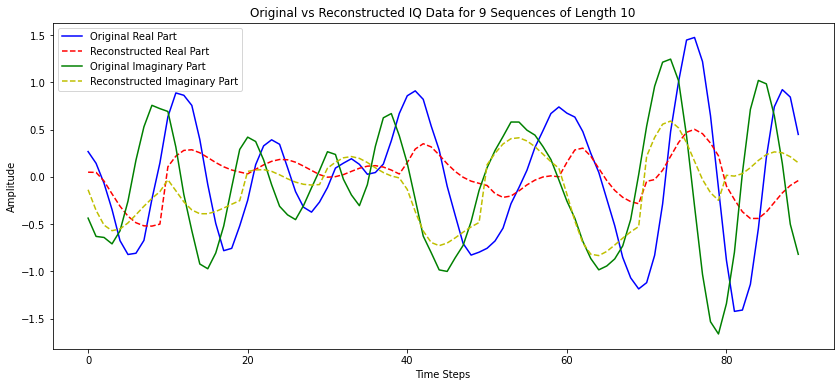

In [2]:
# Repeat for n = 9
n = 9  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()


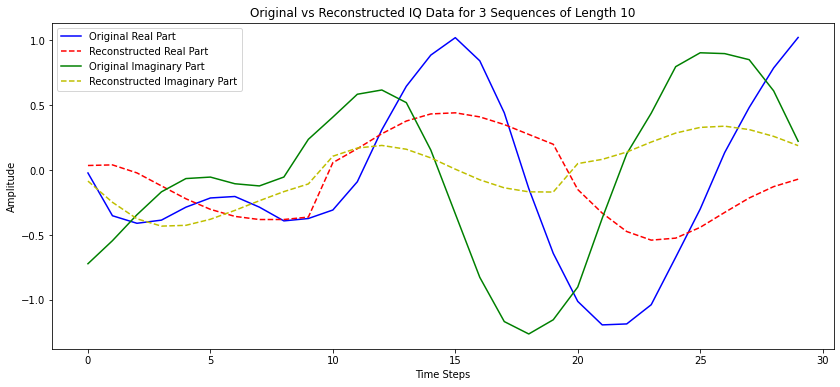

In [3]:
# Repeat for n = 9
n = 3  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()